In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pytorchtools import CNN, GaussianNoise
from adversarialbox.attacks import FGSMAttack, LinfPGDAttack_AE, WassDROAttack_AE, L2PGDAttack_AE
from adversarialbox.train import adv_train, FGSM_train_rnd
from adversarialbox.utils import to_var, pred_batch, test
from layers_compress import Encoder, Generator, Quantizer, AutoencoderQ, StructuredCompressor, SingleEncMultiDec, SingleEncSingleDec
import os
from dro_tools import est_radius, est_radius_structured

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# matplotlib
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rcParams.update({'font.size': 13})
plt.rcParams.update({'lines.linewidth':1.2})
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = None
plt.rcParams['legend.edgecolor'] = 'inherit'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams["font.family"] = "serif"
# plt.rcParams['mathtext.default'] = 'regular'

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(32),
                                            torchvision.transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST('../data/', download=True, train=True, transform=transform)                                 
mnist_test = torchvision.datasets.MNIST('../data/', download=True, train=False, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=5000, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=1000, shuffle=False)

# dset = torch.utils.data.random_split(train_loader.dataset, [5000, 55000])[0]
# train_loader2 = torch.utils.data.DataLoader(dset, batch_size=1, shuffle=True)

In [5]:
def adv_distortion(model, gamma, loader,  *args):
    adversary = WassDROAttack_AE(model=model, k=15, a=1, gamma=gamma)
    dist = 0
    for data in loader:
        data = data[0].to(device)
        X_adv = adversary.perturb(data, None, *args)
        dist += F.mse_loss(X_adv, model(X_adv, *args)).item()*32*32
    return dist/len(loader)

def eval_robust(model, gammas, loader, *args):
    d = []
    for i, gamma in enumerate(gammas):
        d += [adv_distortion(model, gamma, loader,  *args)]
    return d

def center_distortion(model, loader, *args):
    dist = 0
    for data in loader:
        data = data[0].to(device)
        dist += F.mse_loss(data, model(data, *args)).item()*32*32
    return dist/len(loader)

def awgn_distortion(model, variance, loader, *args):
    dist = 0
    for data in loader:
        data = data[0].to(device)
        data_awgn = data + torch.randn(data.size(), device=device) * np.sqrt(variance)
        data_awgn = torch.clip(data_awgn, 0, 1)
        dist += F.mse_loss(data_awgn, model(data_awgn, *args)).item()*32*32
    return dist/len(loader)

def eval_awgn(model, variances, loader, *args):
    d = []
    for variance in variances:
        d += [awgn_distortion(model, variance, loader, *args)]
    return d


# Worst-case-distortion vs wasserstein radius

### Standard

In [6]:
# load a model (for standard or wassDRO)
d = 10
L = 12
saved = torch.load(f'../robust_compression/trained_standard/ae_c_d{d}L{L}.pt', map_location=device)
model = AutoencoderQ(saved['netE'], saved['netG'], saved['netQ'])

In [7]:
# Estimate rhos
gammas = np.linspace(1.33, 1.65, 5)
rhos = np.zeros(len(gammas))
for i, gamma in enumerate(gammas):
    rhos[i] = est_radius(model, gamma, test_loader)
    # rhos[i] = est_radius_structured(model, gamma, test_loader, 1) # for structured
    print(rhos[i])

56.86123046875
49.56004180908203
43.102891540527345
37.48565483093262
32.42134685516358


In [8]:
# Compute worst-case distortion
wcd = eval_robust(model, gammas, test_loader)

Text(0, 0.5, 'Distortion')

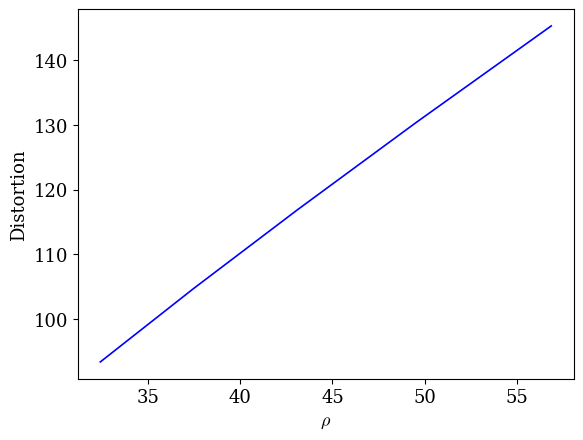

In [9]:
plt.plot(rhos, wcd)
plt.xlabel(r'$\rho$')
plt.ylabel('Distortion')

### Structured

In [10]:
# load a model (for structured)
gamma = 0.36
d_pair = (3,7)
saved = torch.load(f'trained_structured_wass_ball/ae_c_d{d_pair[0]}-{d_pair[1]}L{L}gamma{gamma:.2f}.pt', map_location=device)

# saved = torch.load(f'trained_single_single/ae_c_d{d_pair[0]}-{d_pair[1]}L{L}gamma{gamma:.2f}.pt', map_location=device)
# saved = torch.load(f'trained_idea3_annealed/ae_c_d{d_pair[0]}-{d_pair[1]}L{L}rho{rho}.pt', map_location=device)
model = SingleEncMultiDec(saved['netE'], saved['netQ'], saved['dec_list'], saved['dim_list'])

In [11]:
# Estimate rhos
gammas = np.linspace(0.25, 0.6, 5) # extended rho 50
# gammas = np.linspace(0.42, 0.65, 5) # extended rho 20 DRO
rhos = np.zeros(len(gammas))
for i, gamma in enumerate(gammas):
    rhos[i] = est_radius_structured(model, gamma, test_loader, 1) # for structured
    print(rhos[i])

84.0743392944336
72.37801818847656
60.869842529296875
50.05714302062988
41.13138313293457


In [12]:
# Compute worst-case distortion
wcd = eval_robust(model, gammas, test_loader, 1)

Text(0, 0.5, 'Distortion')

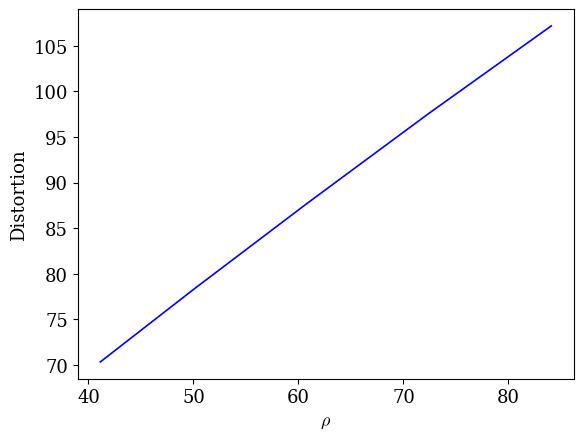

In [13]:
plt.plot(rhos, wcd)
plt.xlabel(r'$\rho$')
plt.ylabel('Distortion')